In [1]:
from typing import Any

import lightning.pytorch as pl
import torch
from lightning.pytorch.callbacks import ModelCheckpoint
import mlflow
from torch.utils.data import DataLoader, Dataset

from src.ml.data.splitting import create_data_splits
from src.ml.modeling import (
    model_factory,
    optimizer_factory,
)
from src.ml.utils.set_seed import set_seed

from datetime import datetime
from loguru import logger
from pathlib import Path
from shutil import copy, copytree, rmtree

import yaml

from src.ml.train_neural_network import train_neural_network
from src.ml.data import data_sets_factory
from src.ml.preprocessing import preprocessing_factory
from src.ml.utils.set_seed import set_seed

In [2]:
CONFIG_FILE = Path("src/ml/config.yaml")

In [3]:
torch.set_default_device(torch.device("cpu"))

In [4]:
# load config file

logger.info("Loading config file.")

with open(CONFIG_FILE, "r") as f:
    config = yaml.safe_load(f)

2024-12-16 13:08:39.151 | INFO     | __main__:<module>:3 - Loading config file.


In [5]:
# load data

logger.info("Loading data.")

_, data_sets = next(iter(data_sets_factory(**config["data_set"])))

# preprocess data

logger.info("Start preprocessing.")

for preprocessing_step in config["preprocessing"]:
    logger.info("Perform {} preprocessing.", preprocessing_step["name"])

    transform = preprocessing_factory(**preprocessing_step)
    data_sets = transform(data_sets)

dataset = data_sets

2024-12-16 13:08:39.157 | INFO     | __main__:<module>:3 - Loading data.
2024-12-16 13:08:39.157 | INFO     | __main__:<module>:9 - Start preprocessing.


In [6]:
train_dataset, val_dataset, test_dataset = create_data_splits(
    dataset, **config["training"]["splitting_config"]
)

In [7]:
train_loader = DataLoader(train_dataset, **config["training"]["dataloader_config"])
test_loader = DataLoader(test_dataset,batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=128)

optimizer = optimizer_factory(**config["training"]["optimizer_config"])
model = model_factory(
    optimizer=optimizer,
    input_example=train_dataset[0],
    **config["training"]["model_config"],
)

In [8]:
from src.ml.modeling.conditional_tree_flow import ConditionalTreeFlow

model = ConditionalTreeFlow.load_from_checkpoint("ml_data/models/debug_dummy_2024_12_16_13_07_37/dummy/epoch=34-val_loss=11.89.ckpt")
model = model.eval()

<Axes: >

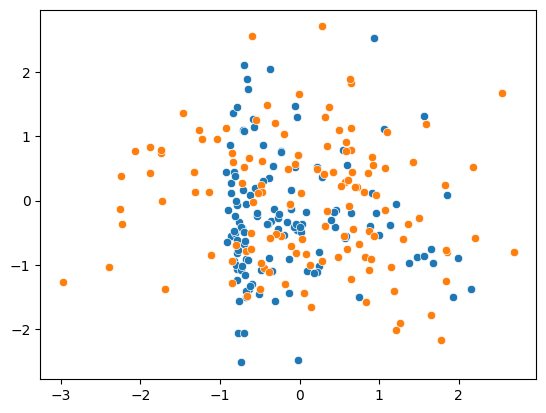

In [9]:
import seaborn as sns
sample = next(iter(val_loader))
latent_space = model.forward(sample)["z"].detach().numpy()
sns.scatterplot(x=latent_space[:, 7], y=latent_space[:, 2])

prior_latent_space = model.prior.sample((128, 9,)).detach().numpy()
sns.scatterplot(x=prior_latent_space[:, 0], y=prior_latent_space[:, 1])

In [10]:
i = iter(val_loader)

In [11]:
sample = next(i)
model.forward(sample)["z"] 

tensor([[ 2.0540, -0.1744,  0.0222,  ..., -0.2326, -0.2597,  0.0762],
        [-0.8846,  0.2626, -0.8877,  ...,  3.5672,  2.4567, -2.3288],
        [ 0.0779, -0.3002, -0.5689,  ..., -1.0236, -0.2412, -0.8442],
        ...,
        [-0.4700,  0.4534,  0.1112,  ...,  0.6781,  2.3712,  0.1726],
        [-0.3570,  1.5762,  0.4634,  ..., -0.8433, -0.8260, -0.1850],
        [-0.8724, -0.2838,  0.1798,  ..., -0.6056, -0.1623,  0.5593]],
       grad_fn=<SubBackward0>)

(-10.0, 15.0)

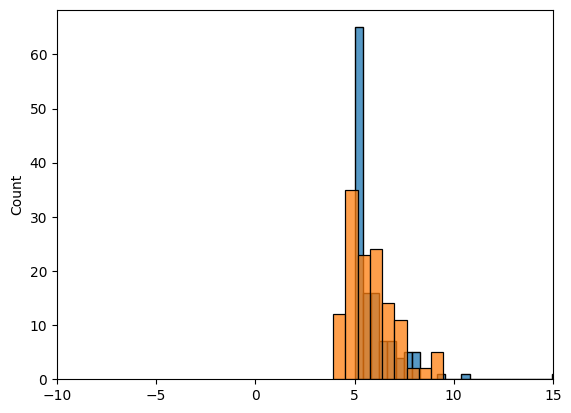

In [12]:
import matplotlib.pyplot as plt
prior = model.prior.sample((128, 9,))
latent = model.forward(sample)
rs = model.inverse(latent)["branch_lengths"]
rs = rs.detach().numpy()
sns.histplot(rs[:, 0])
plt.xlim(-10, 15)
prior = model.prior.sample((128, 9,))
latent = model.forward(sample)
latent["z"] = prior.clone()
rs = model.inverse(latent)["branch_lengths"]
rs = rs.detach().numpy()
sns.histplot(rs[:, 0])
plt.xlim(-10, 15)